## Inicialización

El objetivo es predecir la edad de las personas que aparecen en cada imagen, con la condición de obtener un `error absoluto medio` menor a `8` entrenando un modelo de red neuronal convolucional para el procesamiento de imagenes.

## Cargar datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/`
- La carpeta `final_files` con 7600 fotos
- El archivo `labels.csv` con leyendas, con dos columnas: `file_name` y `real_age`

Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [6]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError

In [7]:
# Importando datos
df_ages = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(validation_split=0.25,
                                   rescale=1/255,
                                   rotation_range=90,
                                   horizontal_flip=True,
                                   vertical_flip=True)
train_datagen_flow = train_datagen.flow_from_directory('/datasets/faces/final_files/',
                                                       class_mode='sparse',
                                                       subset='training',
                                                       target_size=(150, 150),
                                                       seed=12345)


Found 7591 validated image filenames.


## EDA

In [8]:
# Imprimiendo información de "df_ages"
df_ages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [9]:
# Visualizando contenido de "df_ages"
df_ages.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


(114, 114)
(784, 784)
(133, 133)
(370, 370)
(212, 212)
(637, 636)
(412, 412)
(311, 311)
(897, 898)
(724, 724)


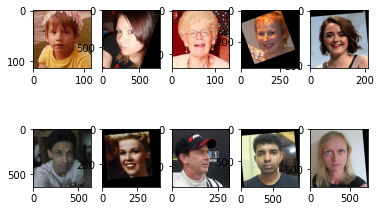

In [11]:
# Imprimiendo 10 imagenes
for i in range(10):
    image = Image.open(f'/datasets/faces/final_files/00000{i}.jpg')
    print(image.size)
    array = np.array(image)
    if i < 5:
        plt.subplot(2, 5, i+1)
        plt.imshow(array)
    else:
        plt.subplot(2, 5, i+1)
        plt.imshow(array)

### Conclusiones

Como podemos observar, tenemos un conjunto de imagenes de diferentes tamaños a lo largo del archivo, estas estan ligadas por su nombre con el conjunto de diferentes edades que para el caso de esta muestra podriamos tomar como ejemplo la primer imagen y la tercera de la primer fila:

- Observamos un niño que nos dice que tiene 4 años.
- Obseravmos una anciana de aproximadamente 80 años.

Y de esa forma es como alimentaremos el modelo.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crear un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [2]:
def load_train(path='/datasets/faces/final_files/'):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    
    # coloca tu código aquí
    train_datagen = ImageDataGenerator(validation_split=0.25,rescale=1/255,fill_mode='nearest')
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=pd.read_csv('/datasets/faces/labels.csv'),
                                                        directory='/datasets/faces/final_files/',
                                                        x_col='file_name',
                                                        y_col='real_age',
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        class_mode='raw',
                                                        subset='training',
                                                        seed=12345)

    return train_gen_flow

In [3]:
def load_test(path='/datasets/faces/final_files/'):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    
    #  coloca tu código aquí
    test_datagen = ImageDataGenerator(validation_split=0.25,rescale=1/255,fill_mode='nearest')
    test_gen_flow = test_datagen.flow_from_dataframe(dataframe=pd.read_csv('/datasets/faces/labels.csv'),
                                                        directory='/datasets/faces/final_files/',
                                                        x_col='file_name',
                                                        y_col='real_age',
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        class_mode='raw',
                                                        subset='validation',
                                                        seed=12345)

    return test_gen_flow

In [4]:
def create_model(input_shape):
    
    """
    Define el modelo
    """
    
    #  coloca tu código aquí
    backbone = ResNet50(input_shape=input_shape, weights='imagenet',include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [5]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        verbose=2,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps
    )

    return model

### Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [6]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Resultado

Coloca aquí el resultado de la plataforma GPU como una celda Markdown.

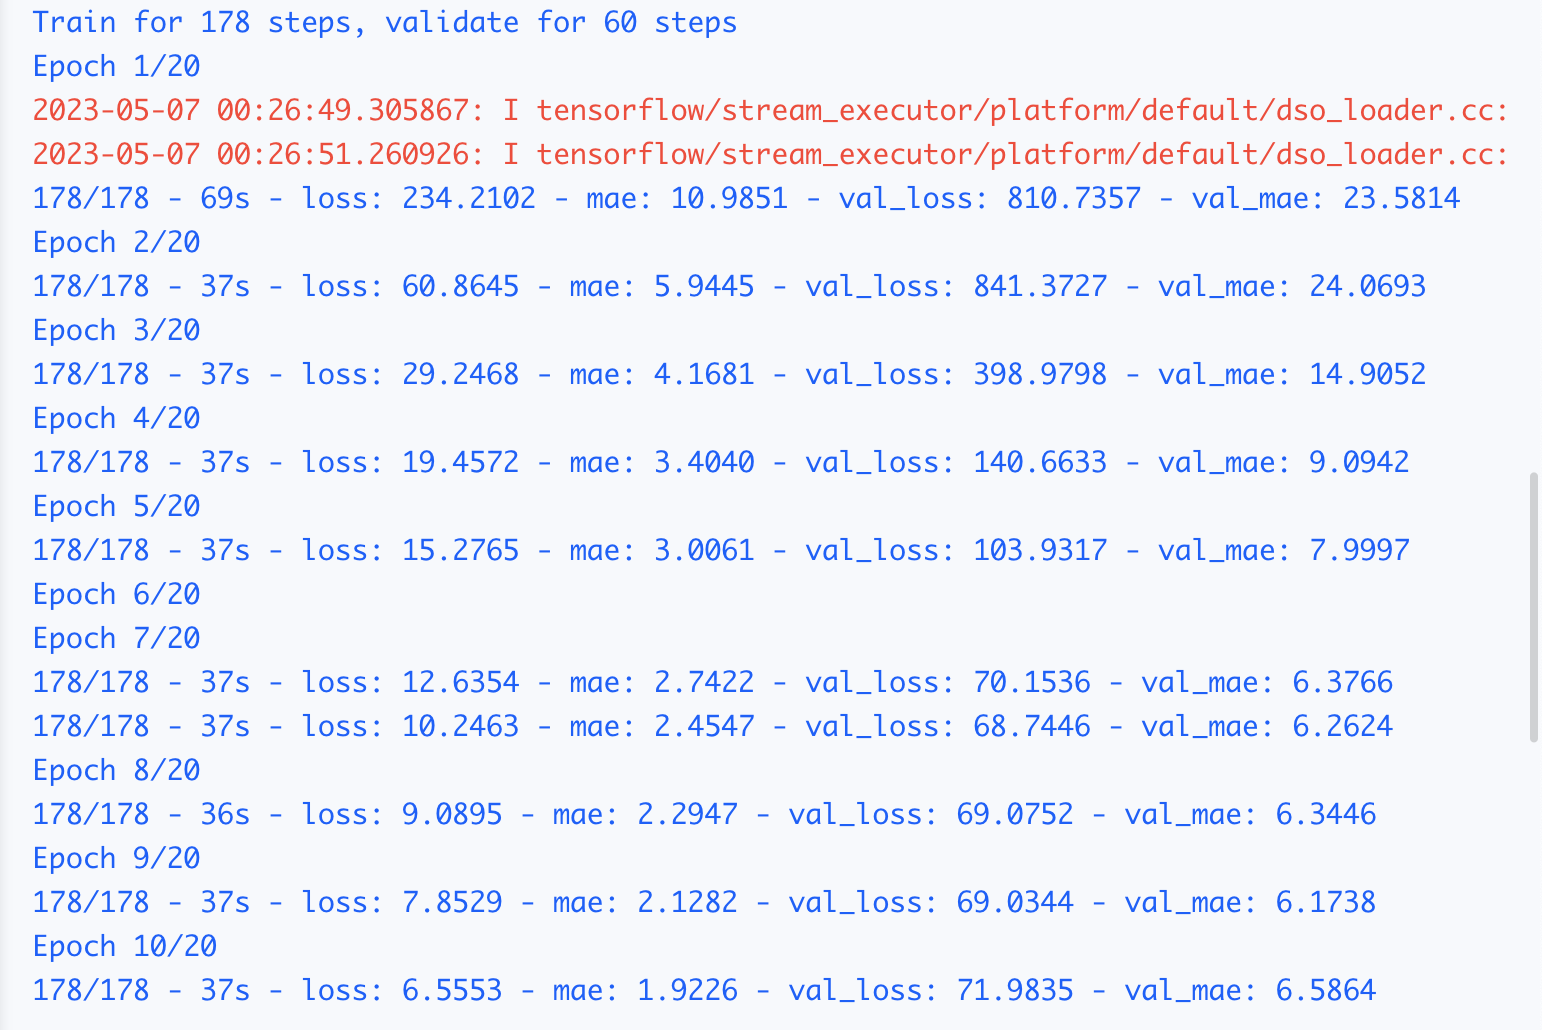

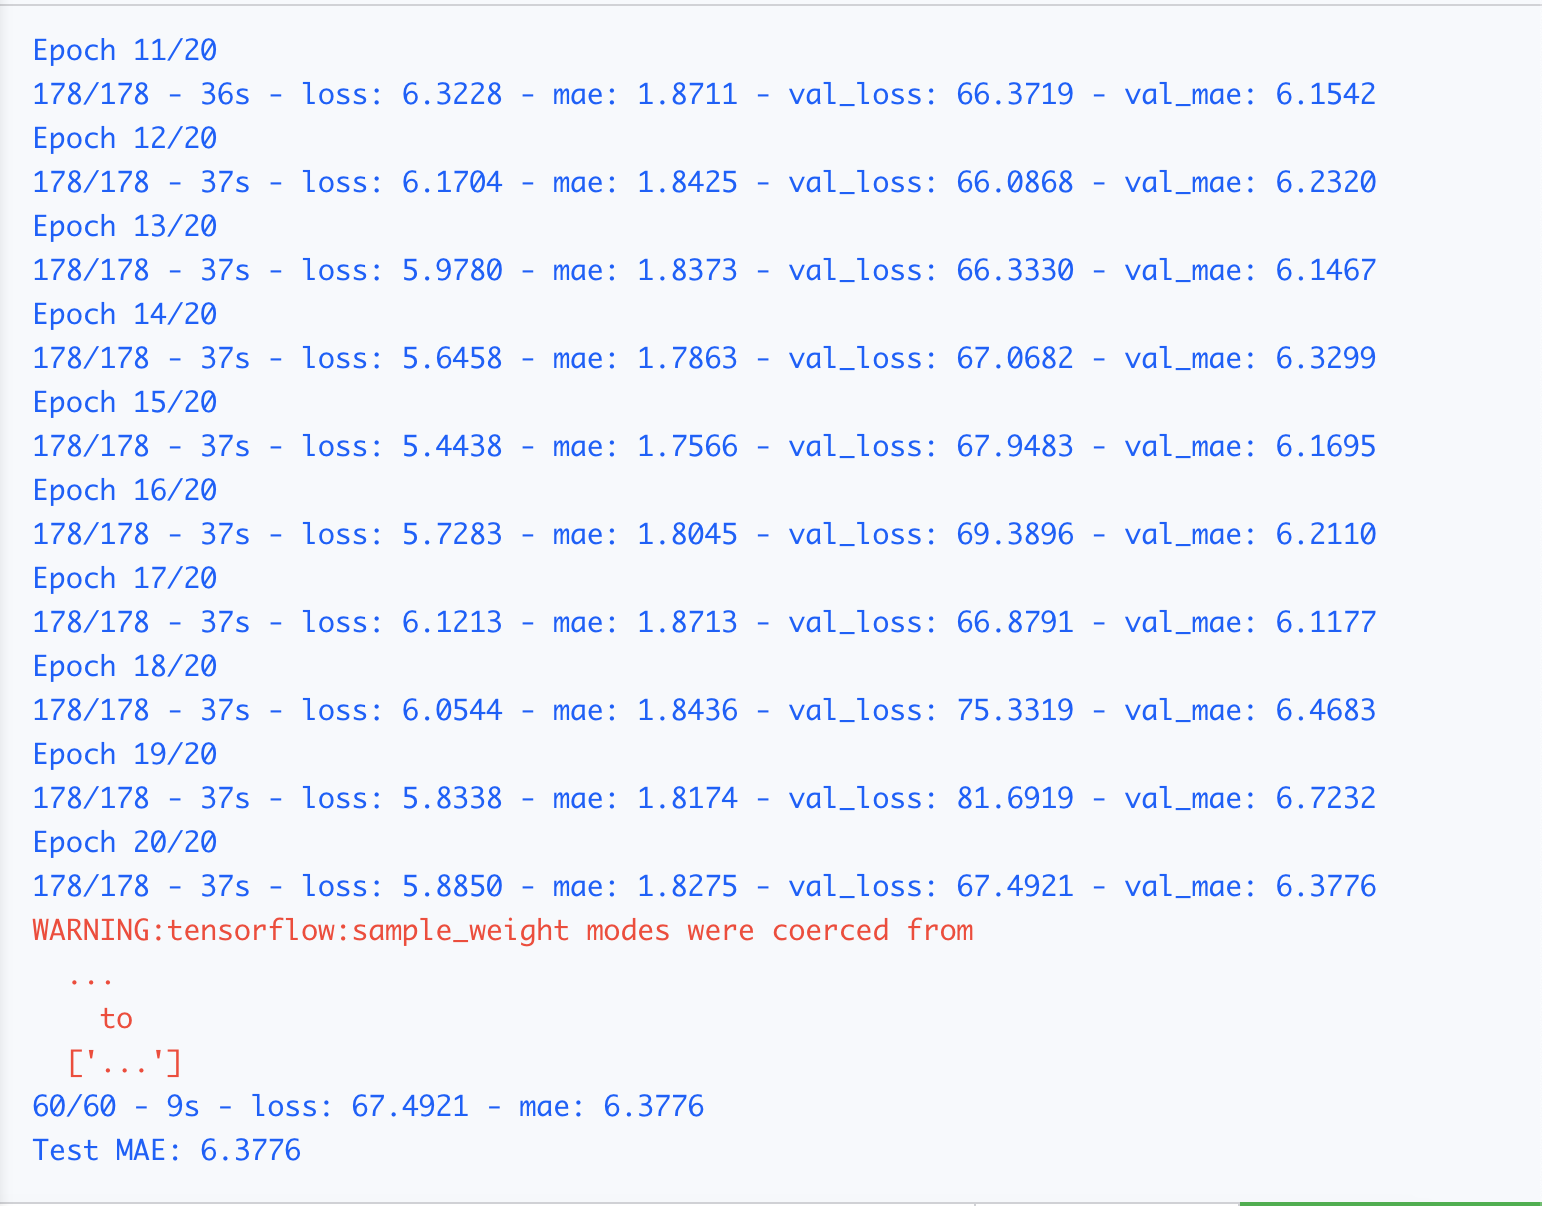

Como podemos observar, a lo largo del entrenamiento a través de 20 epocas, la métrica para el conjunto de validación va arrojando valores que se van encontrando dentro de los parámetros condicionantes de este ejercicio, lo que nos permite que al final el `error absoluto medio` sea de `6.3776`, por lo que podemos concluir que la red neuronal convolucional con arquitectura ResNet50 tiene la capacidad de predecir la edad de los personajes de las fotografías.

## Conclusiones

Al trabajar con redes neuronales convolucionales, podemos darnos cuenta que se tiene la capacidad de lograr practicamente cualquier cosa teniendo en cuenta que esto implica un poder computacional considerable, que si bien la implementación es en extremo sencilla, la configuración y orden que esta va llevando tiene un grado de complejidad elevado, comenzando con las funciones de carga de datos.

Para poder `cargar los datos`, se tiene que considerar que estos vienen de dos fuentes que son:

- Carpeta que contiene las imagenes
- Archivo CSV que contiene el nombre de los archivos de cada imagen con la etiqueta correspondiente que es la variable objetivo.

Al ser cargadas, estas deben pasar por un proceso de ajsute de tamaño puesto que estas pueden ser de distintos tamaños y la red neuronal solo puede procesar datos homogenemos en características (al menos esta en particular), por otro lado es importante investigar el tamaño objetivo con el que trabaja la arquitectura a utilizar que para este caso fue `ResNet50` que si bien se especifíca que es una arquitectura que trabaja para problemas de clasificación, esta puede ser adaptada a modelos de regresión.

Para el `modelo de redes neuronales convolucionales` es importante conocer teoricamente como funciona y bajo que condiciones funciona pues hablando en específico de `ResNet50`, trabaja como una red pre-entrenada con una base de datos llamada `imagenet` la cuál a grandes rasgos contiene on conjunto basto de imagenes que tiene la capacidad de categorizar alrededor de 1000 categorías. Al ser una CNN que tiene un pre-entrenamiento, nos permite hacer uso del conocimiento con el que ya cuenta y aplicarlo a nuestro problema en específico (no siempre es así, depende del problema a abordar) por lo que no es necesario hacer un congelamiento de la red neuronal para posteriormente aplicar una reducción de dimensionalidad antes de la capa de salida.

Por último, la capa de salida de la CNN también con la característica de que es muy sencilla de implementar, debe ser estudiada a detalle pues debemos entender como debe trabajar esta capa para que los resultados de salida sean congruentes con el tipo de problema a abordar que para este caso requerimos de un modelo de regresión lineal pues intentamos predecir un valor continuo como la edad, esta capa debe contener una sola neurona y ser activada con la función `Relu` pues buscamos valores que van de `0` a $\infty$ (entre comillas pues las edades humanas jamas tenderan a infinito).

En conclusión las redes neuronales son implementaciones muy complejas a bajo nivel que permiten abordar un sin fin de problemas entendiendo su arquitectura y propósito.